# Import Dependencies

In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

In [2]:
import gdown
import shutil
from sklearn.model_selection import train_test_split

# Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

# Image Rename (DON'T NEED TO RUN)

In [ ]:
i = 1
for name in os.listdir('/content/gdrive/MyDrive/CSC340 AI/Datasets/Mature'):
  new_name = 'mature_'+str(i).zfill(4)+'.'+name.split('.')[len(name.split('.'))-1]
  i+=1
  shutil.move('/content/gdrive/MyDrive/CSC340 AI/Datasets/Mature/'+name,'/content/gdrive/MyDrive/CSC340 AI/Datasets/Mature/'+new_name)
i = 1
for name in os.listdir('/content/gdrive/MyDrive/CSC340 AI/Datasets/Partially Mature'):
  new_name = 'partiallymature_'+str(i).zfill(4)+'.'+name.split('.')[len(name.split('.'))-1]
  i+=1
  shutil.move('/content/gdrive/MyDrive/CSC340 AI/Datasets/Partially Mature/'+name,'/content/gdrive/MyDrive/CSC340 AI/Datasets/Partially Mature/'+new_name)
i = 1
for name in os.listdir('/content/gdrive/MyDrive/CSC340 AI/Datasets/Unmature'):
  new_name = 'unmature_'+str(i).zfill(4)+'.'+name.split('.')[len(name.split('.'))-1]
  i+=1
  shutil.move('/content/gdrive/MyDrive/CSC340 AI/Datasets/Unmature/'+name,'/content/gdrive/MyDrive/CSC340 AI/Datasets/Unmature/'+new_name)

## Image Augmentation (Don't need to RUN)

In [ ]:
import tensorflow.keras.layers.experimental.preprocessing as prep
data_gen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=60,
      horizontal_flip=True,
      vertical_flip=True,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.1,
      zoom_range=0.2,
      fill_mode='nearest')

In [ ]:
base='/content/gdrive/MyDrive/CSC340 AI/Datasets'
def augmented_img(path):
  count = 0
  filelist = os.listdir(base+'/'+path)
  max = len(filelist)
  print(max, filelist)
  for i in filelist:
    img = plt.imread(base+'/'+path+'/'+i,0)
    img = tf.expand_dims(img, 0)
    data_gen.fit(img)
    extension = i.split('.')
    extension = extension[len(extension)-1]
    for x, val in zip(data_gen.flow(img,save_to_dir=base+'/'+path,save_prefix='aug',save_format=extension),range(10)):pass
    count+=1
    print(path+': '+str(count)+'/'+str(max))

In [ ]:
augmented_img('Mature')
augmented_img('Partially Mature')
augmented_img('Unmature')

# Import Datasets

## Download Dataset from Google Drive

In [3]:
url = "https://drive.google.com/uc?id=1bJaxLQIzgUIrMhoh1kJ0UAJqoVQ0K93F"
output = "papaya_image.zip"
gdown.download(url,output,quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1bJaxLQIzgUIrMhoh1kJ0UAJqoVQ0K93F
To: /content/papaya_image.zip
1.73GB [00:29, 57.8MB/s]


'papaya_image.zip'

In [4]:
!unzip papaya_image.zip

Streaming output truncated to the last 5000 lines.
  inflating: Datasets/Mature/mature_1016.jpg  
  inflating: Datasets/Mature/mature_1017.jpg  
  inflating: Datasets/Mature/mature_1018.jpg  
  inflating: Datasets/Mature/mature_1019.jpg  
  inflating: Datasets/Mature/mature_1020.jpg  
  inflating: Datasets/Mature/mature_1021.jpg  
  inflating: Datasets/Mature/mature_1022.jpg  
  inflating: Datasets/Mature/mature_1023.jpg  
  inflating: Datasets/Mature/mature_1024.jpg  
  inflating: Datasets/Mature/mature_1025.jpg  
  inflating: Datasets/Mature/mature_1026.jpg  
  inflating: Datasets/Mature/mature_1027.jpg  
  inflating: Datasets/Mature/mature_1028.jpg  
  inflating: Datasets/Mature/mature_1029.jpg  
  inflating: Datasets/Mature/mature_1030.jpg  
  inflating: Datasets/Mature/mature_1031.jpg  
  inflating: Datasets/Mature/mature_1032.jpg  
  inflating: Datasets/Mature/mature_1033.jpg  
  inflating: Datasets/Mature/mature_1034.jpg  
  inflating: Datasets/Mature/mature_1035.jpg  
  inflati

In [5]:
!rm -rf papaya_image.zip

# Train Validate Split

### Define directory path

In [6]:
root_dir = './'

In [7]:
base_dir = os.path.join(root_dir,'Datasets')
raw_mature_dir = os.path.join(base_dir,'Mature')
raw_partially_dir = os.path.join(base_dir,'Partially Mature')
raw_unmature_dir = os.path.join(base_dir,'Unmature')

In [8]:
train_dir = os.path.join(base_dir,'train')
train_mature_dir = os.path.join(train_dir,'Mature')
train_partially_mature_dir = os.path.join(train_dir,'Partially Mature')
train_unmature_dir = os.path.join(train_dir,'Unmature')

In [9]:
validate_dir = os.path.join(base_dir,'validate')
validate_mature_dir = os.path.join(validate_dir,'Mature')
validate_partially_mature_dir = os.path.join(validate_dir,'Partially Mature')
validate_unmature_dir = os.path.join(validate_dir,'Unmature')

### Create directory for train and validate

In [10]:
os.mkdir(train_dir)
os.mkdir(train_mature_dir)
os.mkdir(train_partially_mature_dir)
os.mkdir(train_unmature_dir)
os.mkdir(validate_dir)
os.mkdir(validate_mature_dir)
os.mkdir(validate_partially_mature_dir)
os.mkdir(validate_unmature_dir)

### Train and validate split and copy file to target directory

In [11]:
train_size = 0.75

In [12]:
mature_df = pd.DataFrame(data=os.listdir(raw_mature_dir),columns=["filename"])
partially_mature_df = pd.DataFrame(data=os.listdir(raw_partially_dir),columns=["filename"])
unmature_df = pd.DataFrame(data=os.listdir(raw_unmature_dir),columns=["filename"])

In [13]:
mature_train_df, mature_validate_df = train_test_split(mature_df,train_size=train_size,random_state=42)
partially_mature_train_df, partially_mature_validate_df = train_test_split(partially_mature_df,train_size=train_size,random_state=42)
unmature_train_df, unmature_validate_df = train_test_split(unmature_df,train_size=train_size,random_state=42)

In [14]:
mature_train_df

,filename
101,mature_0169.jpg
942,mature_1039.jpg
1270,mature_0858.jpg
107,mature_1411.png
593,mature_0013.jpg
...,...
1130,mature_0198.jpg
1294,mature_1446.png
860,mature_1526.png
1459,mature_0759.jpg


In [15]:
for file in mature_train_df.itertuples():
  shutil.copyfile(os.path.join(raw_mature_dir,file[1]),os.path.join(train_mature_dir,file[1]))
for file in partially_mature_train_df.itertuples():
  shutil.copyfile(os.path.join(raw_partially_dir,file[1]),os.path.join(train_partially_mature_dir,file[1]))
for file in unmature_train_df.itertuples():
  shutil.copyfile(os.path.join(raw_unmature_dir,file[1]),os.path.join(train_unmature_dir,file[1]))
for file in mature_validate_df.itertuples():
  shutil.copyfile(os.path.join(raw_mature_dir,file[1]),os.path.join(validate_mature_dir,file[1]))
for file in partially_mature_validate_df.itertuples():
  shutil.copyfile(os.path.join(raw_partially_dir,file[1]),os.path.join(validate_partially_mature_dir,file[1]))
for file in unmature_validate_df.itertuples():
  shutil.copyfile(os.path.join(raw_unmature_dir,file[1]),os.path.join(validate_unmature_dir,file[1]))

# Preprocessing

In [ ]:
IMAGE_SIZE = 300
BATCH_SIZE = 100

In [16]:
# For VGG => (224,224,3)
IMAGE_SIZE = 224
BATCH_SIZE = 100

In [17]:
def showImage(img):
  plt.imshow(img)
  plt.show()

In [18]:
image_gen_train = ImageDataGenerator(
      rescale=1./255,
      rotation_range=60,
      horizontal_flip=True,
      vertical_flip=True,
      fill_mode='nearest')

In [19]:
train_data_gen = image_gen_train.flow_from_directory(batch_size=BATCH_SIZE,
                                                     directory=train_dir,
                                                     shuffle=True,
                                                     class_mode="categorical",
                                                     target_size=(IMAGE_SIZE,IMAGE_SIZE))

Found 4498 images belonging to 3 classes.


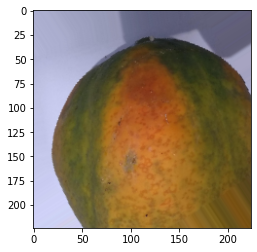

In [151]:
sample_image = train_data_gen[0][0][0]
showImage(sample_image)

In [20]:
train_data_gen.class_indices

{'Mature': 0, 'Partially Mature': 1, 'Unmature': 2}

In [21]:
image_gen_val = ImageDataGenerator(
      rescale=1./255,
      rotation_range=60,
      horizontal_flip=True,
      vertical_flip=True,
      fill_mode='nearest')

In [22]:
val_data_gen = image_gen_val.flow_from_directory(batch_size=BATCH_SIZE,
                                                 directory=validate_dir,
                                                 class_mode="categorical",
                                                 target_size=(IMAGE_SIZE, IMAGE_SIZE))

Found 1503 images belonging to 3 classes.


In [23]:
val_data_gen.class_indices

{'Mature': 0, 'Partially Mature': 1, 'Unmature': 2}

# Model Building

## Construct Model

In [24]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(3)
])

## Construct VGG Model

In [31]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten,Dense
from tensorflow.keras import Model
vgg = VGG16(input_shape=[IMAGE_SIZE,IMAGE_SIZE,3], weights='imagenet', include_top=False)
x = Flatten()(vgg.output)
prediction = Dense(3, activation='softmax')(x)
model = Model(inputs=vgg.input, outputs=prediction)

## Compile model & Summary

In [32]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [33]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

## Train Model

In [34]:
total_train = len(mature_train_df) + len(partially_mature_train_df) + len(unmature_train_df)
total_validate = len(mature_validate_df) + len(partially_mature_validate_df) + len(unmature_validate_df)
epochs = 35
patience = 5
model_name = 'model_vgg.h5'

In [35]:
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    model_name, save_best_only=True)
early_stopping = tf.keras.callbacks.EarlyStopping(patience=patience)

In [36]:
history = model.fit(
    train_data_gen,
    epochs=epochs,
    validation_data=val_data_gen,
    batch_size=BATCH_SIZE,
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/35


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/backend.py:4870: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`categorical_crossentropy` received `from_logits=True`, but '


45/45 [==============================] - 321s 7s/step - loss: 1.4908 - accuracy: 0.3430 - val_loss: 1.0972 - val_accuracy: 0.3792
Epoch 2/35
45/45 [==============================] - 313s 7s/step - loss: 1.0816 - accuracy: 0.3915 - val_loss: 0.9855 - val_accuracy: 0.4165
Epoch 3/35
45/45 [==============================] - 314s 7s/step - loss: 0.6773 - accuracy: 0.6736 - val_loss: 0.3618 - val_accuracy: 0.8503
Epoch 4/35
45/45 [==============================] - 312s 7s/step - loss: 0.3198 - accuracy: 0.8766 - val_loss: 0.2379 - val_accuracy: 0.9075
Epoch 5/35
45/45 [==============================] - 320s 7s/step - loss: 0.2449 - accuracy: 0.9117 - val_loss: 0.2095 - val_accuracy: 0.9195
Epoch 6/35
45/45 [==============================] - 320s 7s/step - loss: 0.3168 - accuracy: 0.8928 - val_loss: 0.2836 - val_accuracy: 0.8869
Epoch 7/35
45/45 [==============================] - 318s 7s/step - loss: 0.2266 - accuracy: 0.9184 - val_loss: 0.1800 - val_accuracy: 0.9321
Epoch 8/35
45/45 [======

## Plot Model Accuracy and Loss

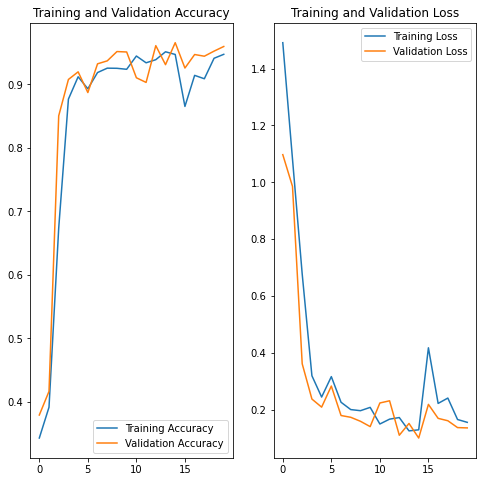

In [37]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(20)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [38]:
history.history

{'accuracy': [0.3430413603782654,
  0.3915073275566101,
  0.6736327409744263,
  0.8766118288040161,
  0.9117385745048523,
  0.8928412795066833,
  0.9184081554412842,
  0.925300121307373,
  0.9250777959823608,
  0.9235215783119202,
  0.9444197416305542,
  0.9337483048439026,
  0.9386394023895264,
  0.9510893821716309,
  0.9468652606010437,
  0.8650511503219604,
  0.9139617681503296,
  0.9086260795593262,
  0.9408625960350037,
  0.9470875859260559],
 'loss': [1.4908193349838257,
  1.0816057920455933,
  0.677257776260376,
  0.31983399391174316,
  0.24493587017059326,
  0.3167506158351898,
  0.22660164535045624,
  0.20085452497005463,
  0.1969522386789322,
  0.2085871696472168,
  0.15018287301063538,
  0.1672280877828598,
  0.17285330593585968,
  0.12593591213226318,
  0.12975384294986725,
  0.4180968999862671,
  0.22252708673477173,
  0.24135561287403107,
  0.16596680879592896,
  0.1559946984052658],
 'val_accuracy': [0.3792415261268616,
  0.4165003299713135,
  0.8502994179725647,
  0.907

## Load Save Model

In [ ]:
model = tf.keras.models.load_model("model.h5")

In [39]:
class_labels = ["mature", "partially mature","unmature"]

In [40]:
probability_model = tf.keras.Sequential([model, 
                                         tf.keras.layers.Softmax()])

In [55]:
model1 = tf.keras.models.load_model("/content/model_vgg.h5")

[[9.9911720e-01 8.8282337e-04 5.7610898e-31]]


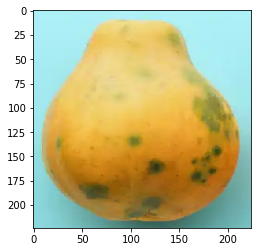

tf.Tensor([0.57579345 0.21219692 0.21200967], shape=(3,), dtype=float32)
This image most likely belongs to mature 
[[9.9500376e-01 4.9962695e-03 8.0143253e-29]]


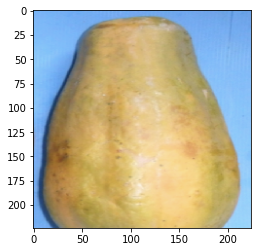

tf.Tensor([0.5742849 0.2133893 0.2123258], shape=(3,), dtype=float32)
This image most likely belongs to mature 
[[2.5183426e-03 9.9748164e-01 4.8102722e-10]]


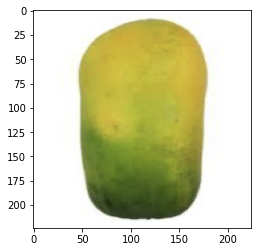

tf.Tensor([0.21267049 0.57519394 0.21213557], shape=(3,), dtype=float32)
This image most likely belongs to partially mature 
[[1.9717301e-04 9.9768460e-01 2.1182434e-03]]


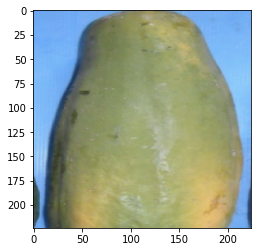

tf.Tensor([0.21216182 0.5752684  0.21256979], shape=(3,), dtype=float32)
This image most likely belongs to partially mature 
[[1.7377423e-02 9.8262262e-01 1.3340442e-13]]


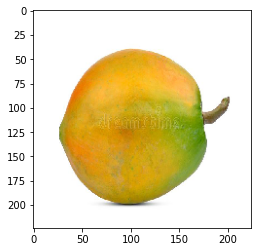

tf.Tensor([0.21700428 0.5697298  0.21326585], shape=(3,), dtype=float32)
This image most likely belongs to partially mature 
[[4.1843964e-07 1.0116020e-02 9.8988360e-01]]


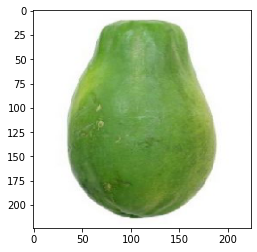

tf.Tensor([0.21271677 0.21487945 0.5724038 ], shape=(3,), dtype=float32)
This image most likely belongs to unmature 


In [66]:
for i in ["/content/health-benefits-of-papaya_copy.jpeg","/content/unknown.png","/content/unknown (1).png","/content/unknown (2).png","/content/ripe.jpeg","/content/Datasets/validate/Unmature/unmature_0103.JPG"]:
  img = tf.keras.preprocessing.image.load_img(
      i, target_size=(IMAGE_SIZE, IMAGE_SIZE)
  )
  img_array = tf.keras.preprocessing.image.img_to_array(img)
  img_array = img_array / 255
  img_array = img_array.reshape(1,IMAGE_SIZE,IMAGE_SIZE,3)
  predictions = model1.predict(img_array)
  print(predictions)
  score = tf.nn.softmax(predictions[0])
  imgplot = plt.imshow(img)
  plt.show()
  print(score)
  print(
      "This image most likely belongs to {} "
      .format(class_labels[np.argmax(score)])
  )

# Save Model to Google Drive

In [50]:
shutil.copy('model_vgg.h5','/content/drive/MyDrive/CSC340 AI/')

'/content/drive/MyDrive/CSC340 AI/model_vgg.h5'